# DTSA-5511:  Week 5 - Kaggle Mini Project

## Use GAN to Create Monet Paintings

## Part 1: Brief Description of the Problem and Data 

This project involves taking an everday photo and modifying it so that it will appear in the style of a Monet painting. This will involve building an GAN consisting of at least two neural networks. These two neural networks will be a generator model and a discriminator model. The generator is a neural network that creates the images. This generator is trained using a discriminator. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real versus generated images.

The data consists of nearly 550MB of image data. The images are divided into two categories: Monet paintings and simple everyday photos. These are unpaired images. By this we mean that for a Monet image, there is no corresponding real-life photo and vice versa. For this reason, we will use a CycleGAN as our choice for a GAN. This choice will be explained later in the notebook when explaining our choice of model architecture.

Please note that Part 6 of this notebook contains all references to code that was used to build this project.

Mini Project link:
https://www.kaggle.com/competitions/gan-getting-started

CycleGAN Research Paper:
https://arxiv.org/pdf/1703.10593.pdf

In [1]:
# The below code is implemented simply to supress warnings when running this model on my system.

def import_tensorflow():
    # Filter tensorflow version warnings
    import os
    # https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
    import warnings
    # https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)
    import tensorflow as tf
    tf.get_logger().setLevel('INFO')
    tf.autograph.set_verbosity(0)
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    return tf

tf = import_tensorflow()    

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import tensorflow.keras as keras
import time
import itertools
import tensorflow_addons as tfa

from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Input, InputLayer, Dropout, Activation, LeakyReLU, ReLU, BatchNormalization, Reshape, Flatten, Conv2DTranspose, UpSampling2D, Concatenate, ZeroPadding2D
from tensorflow.keras.optimizers import Adam

In [3]:
print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.12.0



In [4]:
# Detect the presence of the GPU on this system. Also limit the memory growth to avoid having the model consume all the system memory.

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("NVidia CUDA GPU information:\n")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        print(gpus)
        print("\n")
        #!nvidia-smi
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

NVidia CUDA GPU information:

1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]




## Part 2: Exploratory Data Analysis (EDA)

Connect the model to the data directories on this system.

In [5]:
base_dir = './Input'

Count of the number of tfRecord files and actual individual JPG images.

In [6]:
photoFilenames = tf.io.gfile.glob(base_dir + '/photo_tfrec/*.tfrec')
monetFilenames = tf.io.gfile.glob(base_dir + '/monet_tfrec/*.tfrec')

print('Photo tfRecord File Count:', len(photoFilenames))
print('Monet tfRecord File Count:', len(monetFilenames))

Photo tfRecord File Count: 20
Monet tfRecord File Count: 5


In [7]:
monet_jpg = tf.io.gfile.glob(base_dir + '/monet_jpg/*.jpg')
photo_jpg = tf.io.gfile.glob(base_dir + '/photo_jpg/*.jpg')

print('Photo JPG Count:', len(photo_jpg))
print('Monet JPG Count:', len(monet_jpg))

Photo JPG Count: 7038
Monet JPG Count: 300


Function to convert RGB images from a range of 0 to 255 to a normalized range of -1 to 1.

In [8]:
imgSize = [256, 256]

def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    img = tf.reshape(img, [*imgSize, 3])
    return img

A TFRecord is a Tensorflow file format for storing a sequence of binary records. In this project it is a listing of the images. 

In [9]:
def read_tfrecord(exm):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    exm = tf.io.parse_single_example(exm, tfrecord_format)
    img = decode_image(exm['image'])
    return img

Process the images.

In [10]:
autotune = tf.data.experimental.AUTOTUNE

def load_dataset(fileNames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(fileNames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = autotune)
    return dataset

In [11]:
monetDs = load_dataset(monetFilenames, labeled=True).batch(1)
photoDs = load_dataset(photoFilenames, labeled=True).batch(1)

Now let us take a look at the shape of the images in the Monet and photo image datasets. These images are of a resolution of 256x256 and are RGB (thus 3 channels). The end result is a shape of [256, 256, 3].

In [12]:
exmMonet = next(iter(monetDs))
exmPhoto = next(iter(photoDs))

print("Shape of the Monet image: " + str(exmMonet.shape))
print("Shape of the Photo image: " + str(exmPhoto.shape))

Shape of the Monet image: (1, 256, 256, 3)
Shape of the Photo image: (1, 256, 256, 3)


Now let us take a look at a comparison between the Monet images and the photos. We can make the following observations:

* The photos appear much more crisp then the paintings. There appears to be much more contrast. The Monet paintings appear much more pale.
* With the Monet images they are obviously painted. Thus they have a bit of "fuzziness" to the details.
* Most importantly, the Monet paintings and photos are not paired images.  By this we mean that the photo will not match the painting in terms of the scene shown. They are completely independent. This is important to recognize as this will impact our choice for the CycleGAN.

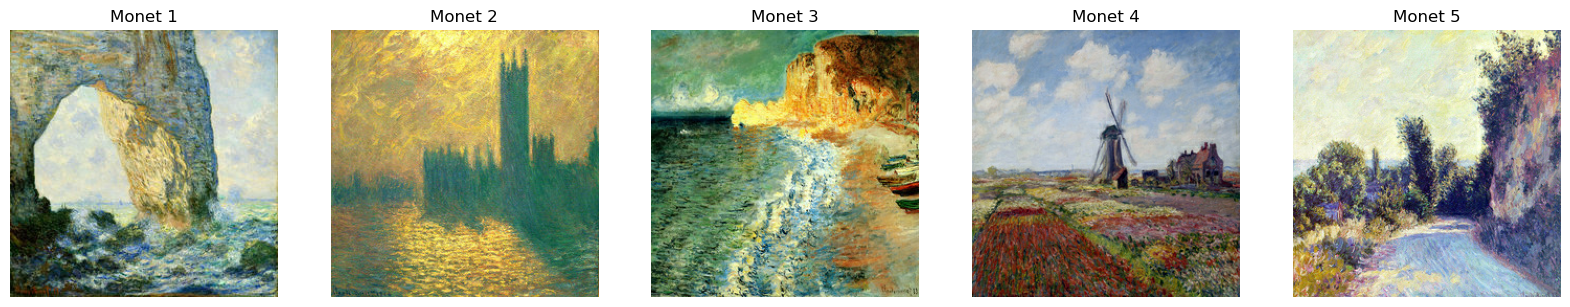

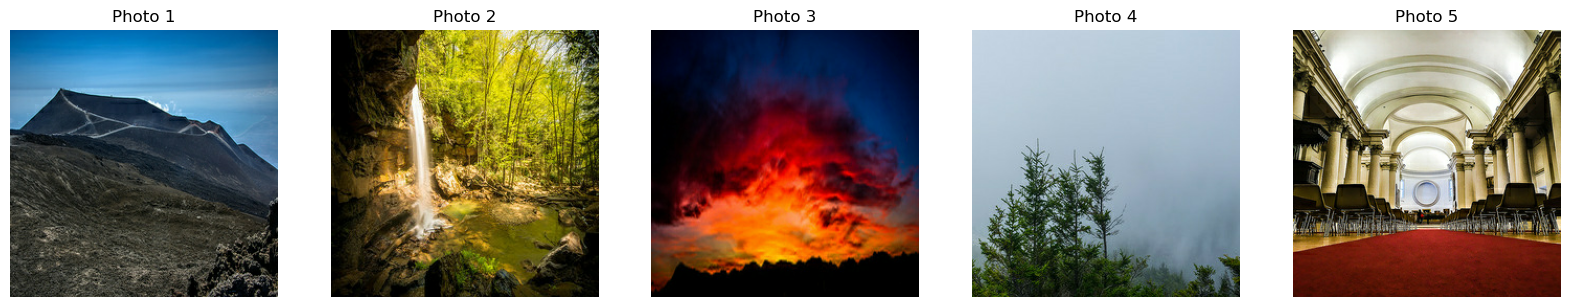

In [13]:
def display_samples(ds, title, samples = 5):
    plt.figure(figsize = (20, 8))
    for i, img in enumerate(ds.take(samples)):
        plt.subplot(1, samples, i + 1)
        plt.title(f'{title} {i + 1}')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

display_samples(monetDs, 'Monet')
display_samples(photoDs, 'Photo')

Finally, create the train dataset for our project.

In [14]:
train_dataset = tf.data.Dataset.zip((monetDs, photoDs))

##  Part 3: Model Architecture

For the architecture of our model we will be using a CycleGAN. With a CycleGAN, no relationship needs to exist between the two data domains. What that means is that the images in the Monet dataset do not have an equivalent image in the photo dataset (for example two images of the same nature scene). Thus they are unpaired images.

To train this CycleGAN model, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another. To perform this task, there will actually be two GANs. One GAN will be used for the forwards transformation and the other GAN for the backwards transformation. So from image domain $X \rightarrow Y$ and backwards $Y \rightarrow X$. 

![](https://i.imgur.com/05Cjt6e.png)

** Note that the CycleGAN code is directly taken from:
* https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

In [61]:
class CycleGAN(keras.Model):
    def __init__(self, monetGenerator, photoGenerator, monetDiscriminator, photoDiscriminator, lambda_cycle = 10):
        super(CycleGAN, self).__init__()
        self.m_gen = monetGenerator
        self.p_gen = photoGenerator
        self.m_disc = monetDiscriminator
        self.p_disc = photoDiscriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        # Gradient tape uses memory to store intermediate results, including inputs and outputs, for use during the backwards pass.
        with tf.GradientTape(persistent=True) as tape:
            # Photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator used to check inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # Discriminator used to check inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {"monet_gen_loss": total_monet_gen_loss, "photo_gen_loss": total_photo_gen_loss, "monet_disc_loss": monet_disc_loss, "photo_disc_loss": photo_disc_loss}

Before we can deploy the above CycleGAN model, we will need to build the necessary functions. We will begin with a code block that creates a single-step downsample function. This will reduce the 2D dimension (width and height) by a default factor of 2. This default factor comes from the stride hyperparameter. Also, from the specification for CycleGAN (noted in the research paper), the Conv2D layer kernel initialization will be a random normal initialized where the mean equals 0 and the standard deviation equal 0.02.

In [16]:
def downsample(filters, kernel_size, apply_instance_norm = True, n_strides = 2):
    model=tf.keras.Sequential()
    model.add(Conv2D(filters, kernel_size,strides = n_strides, padding = 'same', kernel_initializer = tf.keras.initializers.RandomNormal(0.0, 0.02), use_bias = False))
    if apply_instance_norm:
        model.add(tfa.layers.InstanceNormalization())
    model.add(LeakyReLU(0.2))
  
    return model

We will now create a code block to upsample our data. We will use Conv2DTranspose to perform this operation. Conv2DTranspose both performs the upsample operation and interprets the coarse input data to fill in the detail while it is upsampling. It is like a layer that combines the UpSampling2D and Conv2D layers into one layer. The transpose convolutional layer performs an inverse convolution operation. Specifically, the forward and backward passes of the convolutional layer are reversed.

In [17]:
def upsample(filters, kernel_size, apply_dropout = False):

    model= tf.keras.Sequential()
    model.add(Conv2DTranspose (filters, kernel_size, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.RandomNormal(0.0, 0.02), use_bias = False))
    model.add(tfa.layers.InstanceNormalization())
    if apply_dropout:
        model.add(Dropout(0.5))
    model.add(LeakyReLU(0.2))
      
    return model

### Model 1: Initial Model

We will begin with our first model with the basic framework for the other models. We will have a generator which will have a UNET architecture. We can break up this architecture into two parts. The first part we carry out downsampling, and then in the last parts we have upsampling. So we are going to go from (256, 256, 3) to some smaller feature maps. And then we're going to up sample back to (256, 256, 3).

The generator block will also make use of skip connections via concatenation. To quickly explain, during downsampling we will drop from the input size (256, 256, 3) to lower feature maps. Then when we upsample, we move back to the original (256, 256, 3). With a skip connection, we connect matching feature maps from the downsampling and upsampling processes. This helps in solving the problem of vanishing gradients.

In [18]:
def generator1():
    input= Input((256, 256, 3))
    x = input
    store = []
    for filter in [32, 64, 128, 256, 512]:
        x = downsample(filter, 4)(x)
        store.append(x)
  
    for filter in [512,256,128,64,32]:
        # Skip connections
        x = tf.concat([x,store.pop()], axis = -1)
        x = upsample(filter, 4)(x)

    x = Conv2DTranspose(3, 4, strides = 1, padding = 'same',kernel_initializer = tf.keras.initializers.RandomNormal(0.0, 0.02), activation = 'tanh',)(x)

    model = tf.keras.Model(input, x, name= 'unet_generator1')
    return model

generator1().summary()

Model: "unet_generator1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 32  1600        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 64)   32896       ['sequential[0][0]']             
                                                                                    

Now on the other side we have the discriminator which does not require a Unet. The discriminator will take in the (256, 256, 3) image and will see whether this is an image of that domain or a fake image from the generator.

In [19]:
def discriminator1():
    input = Input((256, 256, 3))
    x = input

    x = downsample(32, 4, apply_instance_norm = False)(x)
    x = downsample(64, 4, apply_instance_norm = True)(x)
    x = downsample(128, 4, apply_instance_norm = True)(x)
    x = downsample(256, 4, apply_instance_norm = True,)(x)
    x = downsample(256, 4, apply_instance_norm = True, n_strides = 1)(x)
    x = Conv2D(1, 4, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.RandomNormal(0.0, 0.02))(x)
    
    model = tf.keras.Model(input, x, name = 'discriminator1')
    
    return model

discriminator1().summary()

Model: "discriminator1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_10 (Sequential)  (None, 128, 128, 32)      1536      
                                                                 
 sequential_11 (Sequential)  (None, 64, 64, 64)        32896     
                                                                 
 sequential_12 (Sequential)  (None, 32, 32, 128)       131328    
                                                                 
 sequential_13 (Sequential)  (None, 16, 16, 256)       524800    
                                                                 
 sequential_14 (Sequential)  (None, 16, 16, 256)       1049088   
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 1)      

Both the monet and photo image domains will have identical generators and discriminators.

In [20]:
monetGenerator1 = generator1() 
photoGenerator1 = generator1() 

monetDiscriminator1 = discriminator1() 
photoDiscriminator1 = discriminator1()

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [21]:
def discriminator_loss_fn(real_predictions, fake_predictions):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)
    real_loss = bce(tf.ones_like(real_predictions), real_predictions)
    fake_loss = bce(tf.zeros_like(fake_predictions), fake_predictions)
    discriminator_loss = 0.5 * (real_loss + fake_loss)

    return discriminator_loss

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [22]:
def generator_loss_fn(fake_predictions):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits = True, reduction=tf.keras.losses.Reduction.NONE)
    generator_loss = bce(tf.ones_like(fake_predictions), fake_predictions)
    
    return generator_loss

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [23]:
def cycle_loss_fn(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    cycle_loss = LAMBDA * loss1

    return cycle_loss

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [24]:
def identity_loss_fn(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    identity_loss = LAMBDA * 0.5 * loss
    
    return identity_loss

We will use Adam as the optimizer for all of our generators. For the optimizer we will be using the below settings:

* learning rate = 2e-4
* beta 1 = 0.5

** An important note is that seperate optimizers must be deployed for each individual generator. Even though all the settings are the same, if you try to deploy the shared settings to the generators or discriminators, an error will occur with the fit function.

In [25]:
monet_generator_optimizer1 = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
photo_generator_optimizer1 = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

monet_discriminator_optimizer1 = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
photo_discriminator_optimizer1 = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

We will now compile and train our model. We will train our model 1 for 20 epochs.

In [27]:
cycle_gan1 = CycleGAN(monetGenerator1, photoGenerator1, monetDiscriminator1, photoDiscriminator1)
cycle_gan1.compile(m_gen_optimizer = monet_generator_optimizer1, p_gen_optimizer = photo_generator_optimizer1, m_disc_optimizer = monet_discriminator_optimizer1, p_disc_optimizer = photo_discriminator_optimizer1, gen_loss_fn = generator_loss_fn, disc_loss_fn = discriminator_loss_fn, cycle_loss_fn = cycle_loss_fn, identity_loss_fn = identity_loss_fn)

startTime1 = time.time()
history1 = cycle_gan1.fit(train_dataset, epochs = 20)
endTime1 = time.time()

model1_train_time = round((endTime1 - startTime1) / 60, 3)
print(f"\nModel 1 Training Time = {model1_train_time} minutes")

Epoch 1/20
300/300 [==============================] - 320s 861ms/step - monet_gen_loss: 7.1234 - photo_gen_loss: 7.2664 - monet_disc_loss: 0.6879 - photo_disc_loss: 0.6879
Epoch 2/20
300/300 [==============================] - 260s 865ms/step - monet_gen_loss: 6.4578 - photo_gen_loss: 6.5783 - monet_disc_loss: 0.6573 - photo_disc_loss: 0.6601
Epoch 3/20
300/300 [==============================] - 257s 856ms/step - monet_gen_loss: 6.1205 - photo_gen_loss: 6.2217 - monet_disc_loss: 0.6443 - photo_disc_loss: 0.6425
Epoch 4/20
300/300 [==============================] - 265s 882ms/step - monet_gen_loss: 5.9463 - photo_gen_loss: 6.0782 - monet_disc_loss: 0.6455 - photo_disc_loss: 0.6253
Epoch 5/20
300/300 [==============================] - 261s 870ms/step - monet_gen_loss: 5.6796 - photo_gen_loss: 5.8452 - monet_disc_loss: 0.6525 - photo_disc_loss: 0.6163
Epoch 6/20
300/300 [==============================] - 256s 854ms/step - monet_gen_loss: 5.5586 - photo_gen_loss: 5.7057 - monet_disc_loss: 0

Here are the results from the training of model 1:

* Total training time was 87.283 minutes.
* The Monet generator loss went from 7.1234 to 4.6348. This was a decrease of 2.4886.
* The photo generator loss went from 7.2664 to 4.6495. This was a decrease of 2.6169.
* The Monet discriminator loss went from 0.6879 to 0.5656. This was a decrease of 0.1223.
* The photo discriminator loss went from 0.6879 to 0.5435. This was a decrease of 0.1444.

Now let us explore some of the generated Monet images.

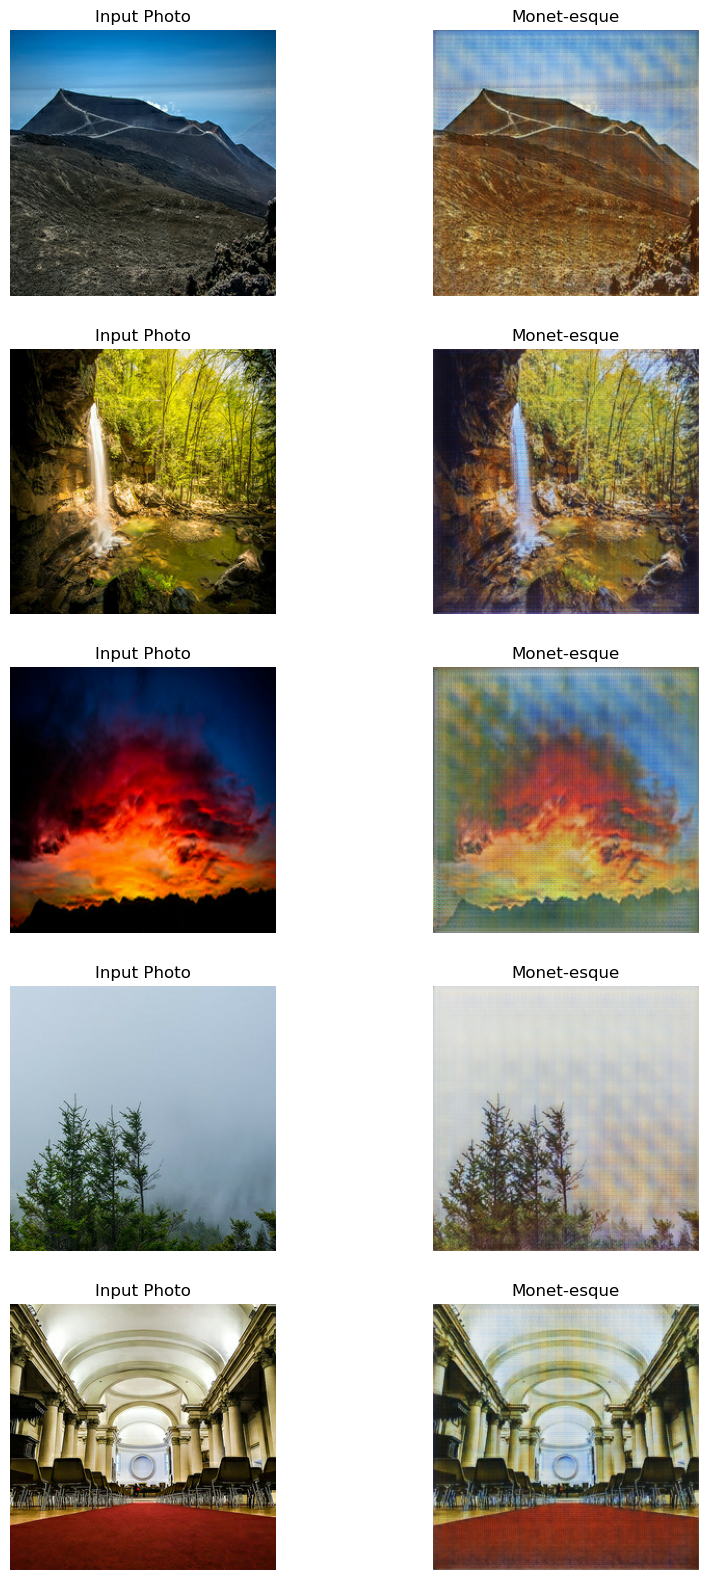

In [29]:
_, ax = plt.subplots(5, 2, figsize = (10, 20))
for i, img in enumerate(photoDs.take(5)):
    prediction = monetGenerator1(img, training = False)[0].numpy()
    
    # Ensure to recode the image back to the standard RGB range of 0 to 255.
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Model 2: Deeper Model

Many of the sample CycleGAN implementation examples employ slighlty deeper neural networks for both the generator and discriminator. We will deploy these models to see the difference.

In [30]:
def generator2():
    input= Input((256, 256, 3))
    x = input
    x = downsample(64, 4, apply_instance_norm = False)(x)
    store = []
    for filter in [128, 256, 512, 512, 512, 512, 512]:
        x = downsample(filter, 4)(x)
        store.append(x)
  
    for filter in [512, 512, 512]:
        # Skip connections
        x = tf.concat([x,store.pop()], axis = -1)
        x = upsample(filter, 4, apply_dropout = True)(x)
        
    for filter in [512, 256, 128, 64]:
        # Skip connections
        x = tf.concat([x,store.pop()], axis = -1)
        x = upsample(filter, 4)(x)

    x = Conv2DTranspose(3, 4, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.RandomNormal(0.0, 0.02), activation = 'tanh',)(x)

    model = tf.keras.Model(input, x, name= 'unet_generator2')
    return model

generator2().summary()

Model: "unet_generator2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_45 (Sequential)     (None, 128, 128, 64  3072        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_46 (Sequential)     (None, 64, 64, 128)  131328      ['sequential_45[0][0]']          
                                                                                    

In [31]:
def discriminator2():

    input = Input((256, 256, 3))
    x = input

    x = downsample(64, 4, apply_instance_norm = False)(x)
    x = downsample(128, 4, apply_instance_norm = True)(x)
    x = downsample(256, 4, apply_instance_norm = True)(x)
    x = downsample(512, 4, apply_instance_norm = True, n_strides = 1)(x)
    x = Conv2D(1, 4, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.RandomNormal(0.0, 0.02))(x)
    
    model = tf.keras.Model(input, x, name = 'discriminator2')
    
    return model

discriminator2().summary()

Model: "discriminator2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_60 (Sequential)  (None, 128, 128, 64)      3072      
                                                                 
 sequential_61 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_62 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 sequential_63 (Sequential)  (None, 32, 32, 512)       2098176   
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 1)         8193      
                                                                 
Total params: 2,765,569
Trainable params: 2,765,569


In [32]:
monetGenerator2 = generator2() 
photoGenerator2 = generator2() 

monetDiscriminator2 = discriminator2() 
photoDiscriminator2 = discriminator2()

In [33]:
monet_generator_optimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
photo_generator_optimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

monet_discriminator_optimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
photo_discriminator_optimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [34]:
cycle_gan2 = CycleGAN(monetGenerator2, photoGenerator2, monetDiscriminator2, photoDiscriminator2)
cycle_gan2.compile(m_gen_optimizer = monet_generator_optimizer2, p_gen_optimizer = photo_generator_optimizer2, m_disc_optimizer = monet_discriminator_optimizer2, p_disc_optimizer = photo_discriminator_optimizer2, gen_loss_fn = generator_loss_fn, disc_loss_fn = discriminator_loss_fn, cycle_loss_fn = cycle_loss_fn, identity_loss_fn = identity_loss_fn)

startTime2 = time.time()
history2 = cycle_gan2.fit(train_dataset, epochs = 20)
endTime2 = time.time()

model2_train_time = round((endTime2 - startTime2) / 60, 3)
print(f"\nModel 2 Training Time = {model2_train_time} minutes")

Epoch 1/20
300/300 [==============================] - 387s 1s/step - monet_gen_loss: 7.4371 - photo_gen_loss: 7.5367 - monet_disc_loss: 0.6846 - photo_disc_loss: 0.6950
Epoch 2/20
300/300 [==============================] - 315s 1s/step - monet_gen_loss: 6.4346 - photo_gen_loss: 6.4479 - monet_disc_loss: 0.6321 - photo_disc_loss: 0.6526
Epoch 3/20
300/300 [==============================] - 318s 1s/step - monet_gen_loss: 5.8467 - photo_gen_loss: 5.8538 - monet_disc_loss: 0.6349 - photo_disc_loss: 0.6439
Epoch 4/20
300/300 [==============================] - 305s 1s/step - monet_gen_loss: 5.2885 - photo_gen_loss: 5.3752 - monet_disc_loss: 0.6492 - photo_disc_loss: 0.6300
Epoch 5/20
300/300 [==============================] - 313s 1s/step - monet_gen_loss: 5.0904 - photo_gen_loss: 5.2524 - monet_disc_loss: 0.6418 - photo_disc_loss: 0.6136
Epoch 6/20
300/300 [==============================] - 342s 1s/step - monet_gen_loss: 5.0340 - photo_gen_loss: 5.2249 - monet_disc_loss: 0.6361 - photo_disc

Here are the results from the training of model 2:

* Total training time was 136.357 minutes. This is significantly longer than model 1 though to be expected given the deeper neural networks.
* The Monet generator loss went from 7.4371 to 3.9629. This was a decrease of 3.4742.
* The photo generator loss went from 7.5367 to 3.9792. This was a decrease of 3.5575.
* The Monet discriminator loss went from 0.6846 to 0.6339. This was a decrease of 0.0507.
* The photo discriminator loss went from 0.6950 to 0.6138. This was a decrease of 0.0812
* The end loss results for the generators are lower than model 1. However, the discriminator loss final values are slightly higher.

Now let us explore some of the generated Monet images.

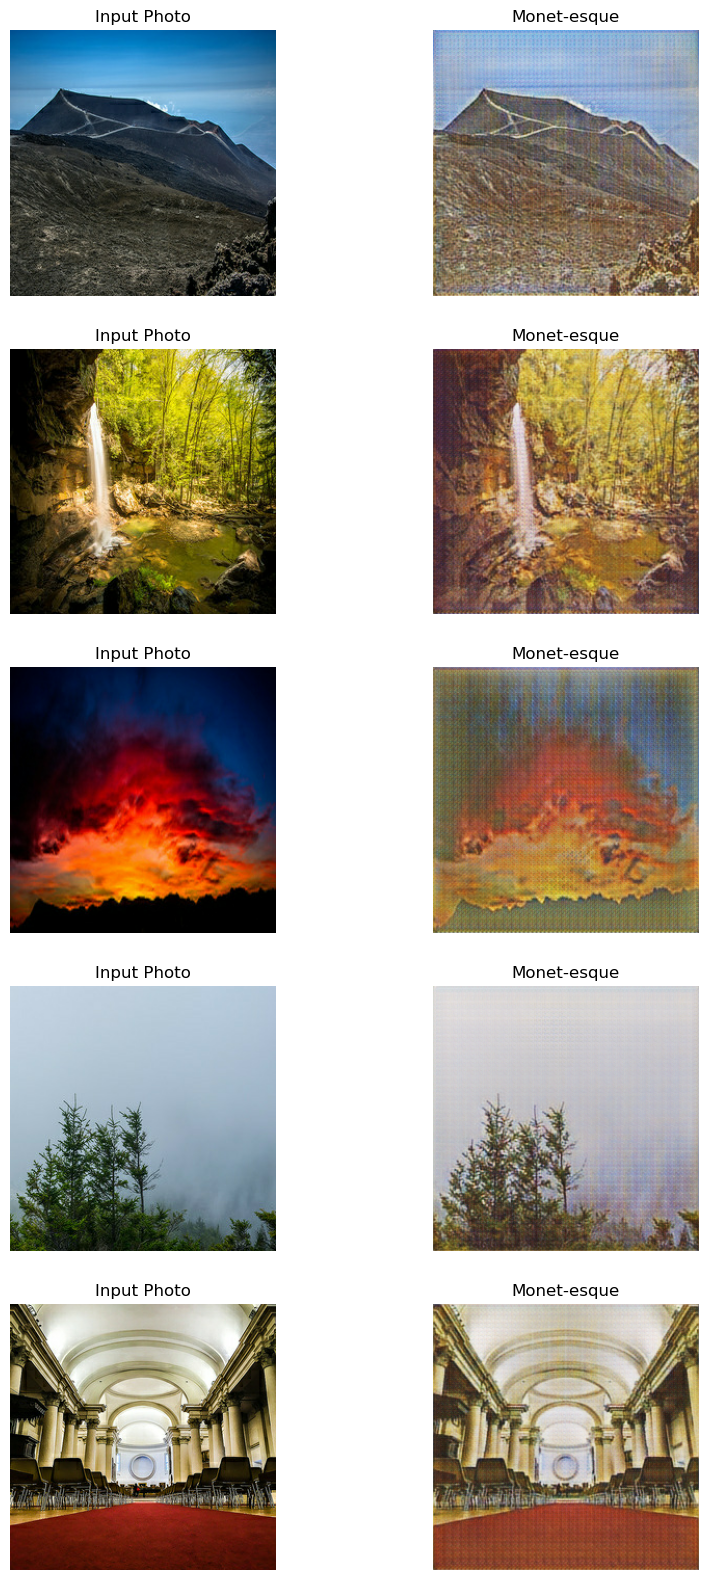

In [35]:
_, ax = plt.subplots(5, 2, figsize = (10, 20))
for i, img in enumerate(photoDs.take(5)):
    prediction = monetGenerator2(img, training = False)[0].numpy()
    
    # Ensure to recode the image back to the standard RGB range of 0 to 255.
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Model 3: Modify Hyperparameters

We will now take model 2 and tune a couple of hyperparameters to see the results. The below two parameters for the Adam optimizer were changed:

* The learning rate is now 2e-3.
* Beta 1 will be set to default. This will be a value of 0.9. 

In [65]:
monetGenerator3 = generator2() 
photoGenerator3 = generator2() 

monetDiscriminator3 = discriminator2() 
photoDiscriminator3 = discriminator2()

In [37]:
monet_generator_optimizer3 = tf.keras.optimizers.Adam(2e-3)
photo_generator_optimizer3 = tf.keras.optimizers.Adam(2e-3)

monet_discriminator_optimizer3 = tf.keras.optimizers.Adam(2e-3)
photo_discriminator_optimizer3 = tf.keras.optimizers.Adam(2e-3)

In [38]:
cycle_gan3 = CycleGAN(monetGenerator3, photoGenerator3, monetDiscriminator3, photoDiscriminator3)
cycle_gan3.compile(m_gen_optimizer = monet_generator_optimizer3, p_gen_optimizer = photo_generator_optimizer3, m_disc_optimizer = monet_discriminator_optimizer3, p_disc_optimizer = photo_discriminator_optimizer3, gen_loss_fn = generator_loss_fn, disc_loss_fn = discriminator_loss_fn, cycle_loss_fn = cycle_loss_fn, identity_loss_fn = identity_loss_fn)

startTime3 = time.time()
history3 = cycle_gan3.fit(train_dataset, epochs = 20)
endTime3 = time.time()

model3_train_time = round((endTime3 - startTime3) / 60, 3)
print(f"\nModel 3 Training Time = {model3_train_time} minutes")

Epoch 1/20
300/300 [==============================] - 396s 1s/step - monet_gen_loss: 7.6745 - photo_gen_loss: 7.8749 - monet_disc_loss: 0.7589 - photo_disc_loss: 0.7559
Epoch 2/20
300/300 [==============================] - 326s 1s/step - monet_gen_loss: 6.2443 - photo_gen_loss: 6.3870 - monet_disc_loss: 0.7160 - photo_disc_loss: 0.7084
Epoch 3/20
300/300 [==============================] - 319s 1s/step - monet_gen_loss: 5.7309 - photo_gen_loss: 5.8401 - monet_disc_loss: 0.7073 - photo_disc_loss: 0.7182
Epoch 4/20
300/300 [==============================] - 325s 1s/step - monet_gen_loss: 5.4584 - photo_gen_loss: 5.5340 - monet_disc_loss: 0.6963 - photo_disc_loss: 0.7057
Epoch 5/20
300/300 [==============================] - 319s 1s/step - monet_gen_loss: 5.2280 - photo_gen_loss: 5.3013 - monet_disc_loss: 0.6830 - photo_disc_loss: 0.6907
Epoch 6/20
300/300 [==============================] - 325s 1s/step - monet_gen_loss: 5.0898 - photo_gen_loss: 5.1572 - monet_disc_loss: 0.6804 - photo_disc

Here are the results from the training of model 3:

* Total training time was 109.403 minutes. This is shorter than model 2 but still significantly longer than model 1.
* The Monet generator loss went from 7.6745 to 3.9854. This was a decrease of 3.6891.
* The photo generator loss went from 7.8749 to 4.0811. This was a decrease of 3.7939.
* The Monet discriminator loss went from 0.7589 to 0.6625. This was a decrease of 0.0964.
* The photo discriminator loss went from 0.7559 to 0.6443. This was a decrease of 0.1116.
* The end loss results are fairly similar to those of model 2. Not surprising since we only performed some small hyperparameter tuning.

Now let us explore some of the generated Monet images.

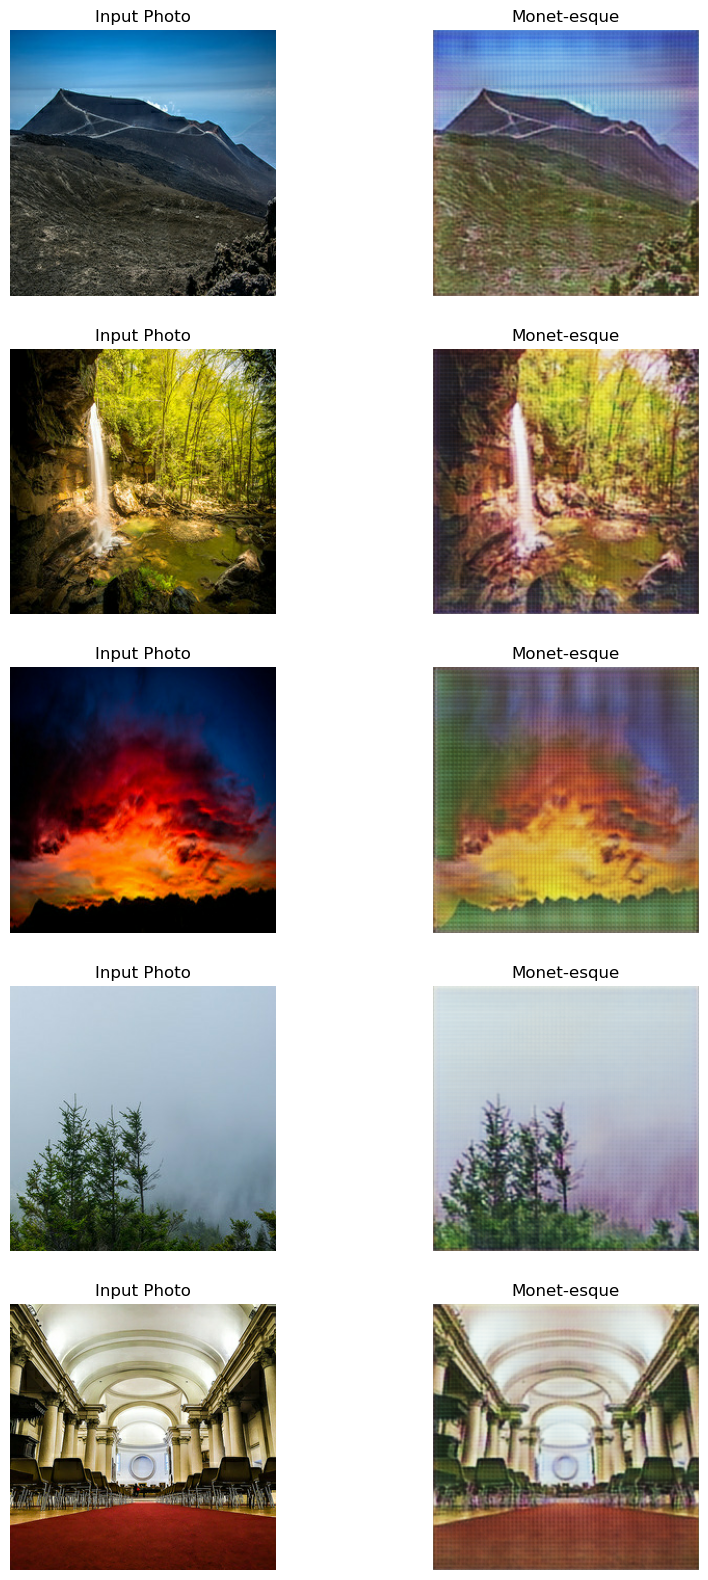

In [39]:
_, ax = plt.subplots(5, 2, figsize = (10, 20))
for i, img in enumerate(photoDs.take(5)):
    prediction = monetGenerator3(img, training=False)[0].numpy()
    
    # Ensure to recode the image back to the standard RGB range of 0 to 255.
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Part 4: Results and Analysis

To recap, let us look at a comparison of the 3 models. We can make the following observations:

* All three models appear to have a lower contrast between bright and dark colors as compared to the original image. 
* We can clearly see an underlying square pattern in the generated images. Of note that during testing, some training was done with a lower epoch count. The squares were much larger in size in these results. Thus, it is possible that running for more epochs will reduce this effect.
* Models 1 and 2 appear to be much brighter and saturated relative to the original photo. Model 3 seems to be the closest to the original photo.
* The three models took a significant amount of time to train. These are very deep models thus this was expected.

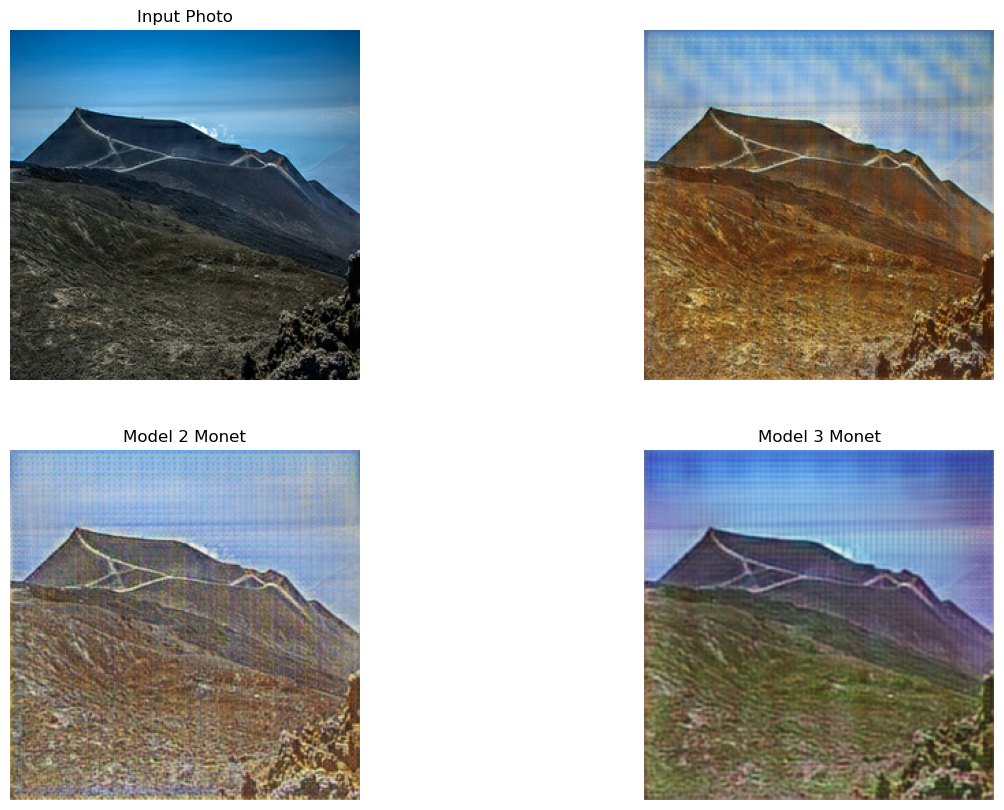

In [62]:
_, ax = plt.subplots(2, 2, figsize = (15, 10))
#for i, img in enumerate(photoDs.take(1)):

img = photoDs.take(1)
img = next(iter(img))

prediction1 = monetGenerator1(img, training=False)[0].numpy()
prediction2 = monetGenerator2(img, training=False)[0].numpy()
prediction3 = monetGenerator3(img, training=False)[0].numpy()
    
# Ensure to recode the image back to the standard RGB range of 0 to 255.
prediction1 = (prediction1 * 127.5 + 127.5).astype(np.uint8)
prediction2 = (prediction2 * 127.5 + 127.5).astype(np.uint8)
prediction3 = (prediction3 * 127.5 + 127.5).astype(np.uint8)
img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

ax[0, 0].imshow(img)
ax[0, 1].imshow(prediction1)
ax[1, 0].imshow(prediction2)
ax[1, 1].imshow(prediction3)
ax[0, 0].set_title("Input Photo")
ax[1, 1].set_title("Model 1 Monet")
ax[1, 0].set_title("Model 2 Monet")
ax[1, 1].set_title("Model 3 Monet")
ax[0, 0].axis("off")
ax[0, 1].axis("off")
ax[1, 0].axis("off")
ax[1, 1].axis("off")

plt.show()

## Part 5: Conclusion

The CycleGAN was able to accomplish our goal. It was able to learn the style of the Monet paintings, and transfer that style to unpaired photos that we added to the model as inputs. Model 3 gave us the best results. There are two possible factors for this:

* The number of epochs used in training.
* Tuning of the hyperparameters.

In experimenting with the models, increasing the number of epochs did show benefits. However, the time needed to train is extremely significant. This notebook was tested on a computer with a single GPU. Upgrading this setup will allow for more experimentation.

For the model submission to Kaggle, model 3 will be used.

In [64]:
#! mkdir ../images

import PIL
import shutil

save_dir = './Monet_output/'

i = 1
for img in photoDs:
    prediction = monetGenerator3(img, training = False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(save_dir + str(i) + ".jpg")
    i += 1

##  Part 6: Reference

* https://www.kaggle.com/code/jesperdramsch/understanding-and-improving-cyclegans-tutorial
* https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
* https://github.com/Neuralearn/deep-learning-with-tensorflow-2/blob/main/deep%20learning%20for%20image%20generation/6-CycleGAN%20By%20Neuralearn.ai-.ipynb